In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on graph (the Graph DGMRF model) on the Wikipedia example

The original article is [here](https://proceedings.mlr.press/v162/oskarsson22a/oskarsson22a.pdf) and the code can be found [here](https://github.com/joeloskarsson/graph-dgmrf/blob/main/utils.py).

The experiment consists in predicting unobserved node attributes (a real number) when the graph is known and the observed node attributes are known too.

The results of this notebook are to be compared with the Table 1 of the article. Our implmentation seems to perform better. We thus seem able to reasonably infer the unobserved node attributes.

In [2]:
from functools import partial
import jax
#jax.config.update('jax_platforms', "cpu")
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

2024-07-07 17:22:58.869986: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## Load the wikipedia graph data for chameleon 🦎

**Note that it would be good to have a more rigorous preprocessing of the data: e.g. isolated nodes** (see [original code](https://github.com/joeloskarsson/graph-dgmrf/blob/4c640b3eba025fdfdec8db977ca0f484748737d1/data_loading/wiki.py#L41))

In [4]:
from dgmrf.utils import get_N_y_D_A
N, y, D, A = get_N_y_D_A("musae_chameleon")

As stated in the article, **50% of nodes will be unobserved**, randomly and uniformly chosen and optionally add noise

In [5]:
from dgmrf.utils import get_y_with_mask_and_noise
true_sigma_noise = 0.01
key, subkey = jax.random.split(key, 2)
y, y_masked, mask = get_y_with_mask_and_noise(y, y.shape[0] // 2, subkey, true_sigma_noise)

### Define the DGMRF components

In [6]:
from dgmrf.models import DGMRF, MeanField, FactorizedS

In [7]:
L = 3
Nq = 5

In [8]:
y = y.flatten()
mask = mask.flatten()

In [9]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(
    subkey,
    L,
    A_D=(A, D),
    log_det_method="eigenvalues",
    with_bias=True,
    non_linear=False,
)


Instanciate the variational distribution. The factorized distribution is much slower. MF variational distribution is already very satisfying.

In [10]:
key, subkey1, subkey2 = jax.random.split(key, 3)

q_phi = MeanField(N=N, key=subkey1)
# q_phi = FactorizedS(
#     N=N,
#     dgmrf_args=(subkey1, 1),
#     dgmrf_kwargs= {
#         "A_D":(A, D),
#         "log_det_method":"eigenvalues"
#     },
#     key=subkey2
# )

Define the Model equinox module `(DGMRF, VariationalDistribution, noise_parameter_array)`. This is just a container-like structure

In [11]:
from dgmrf.train import Model
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))

### Variational inference to compute model parameters

In [12]:
n_iter = 5000
lr_graph = 1e-5

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.rprop(lr), 'log_sigma': optax.adam(0), 'q_phi': optax.rprop(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [13]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

print_rate = 1000
key, subkey = jax.random.split(key, 2)

model, loss_val, opt_state = train_loop(dgmrf_elbo, model, y_masked, n_iter, tx, opt_state, subkey, print_rate, N, Nq, mask=mask)

Iteration 0, loss_value = -388009.90625
Iteration 1000, loss_value = 32.31873321533203
Iteration 2000, loss_value = 34.536720275878906
Iteration 3000, loss_value = 35.79438400268555
Iteration 4000, loss_value = 36.66947555541992
End of training (iteration 5000), loss_value = 37.36500549316406


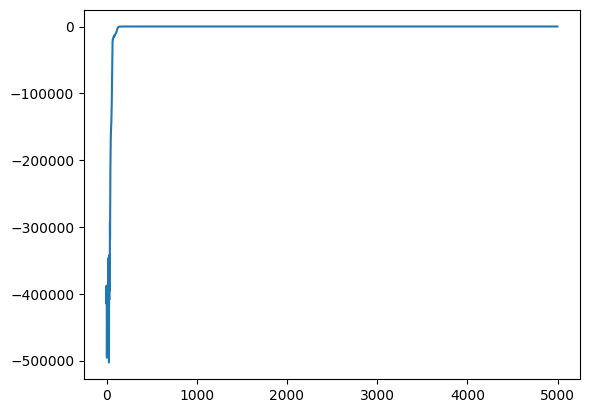

In [14]:
plt.plot((loss_val))
plt.show()

The means of the variational distribution will be the inferred values as a first approximation..

In [15]:
rmse_nu_phi = jnp.sqrt(jnp.mean((model.posterior.params["nu"] - y) ** 2))
print("RMSE with the means of the variational distribution", rmse_nu_phi)

RMSE with the means of the variational distribution 1.3027978


**it already provides a good estimation. Even better than the results provided in Table 1 of the article**

For the record :

- using the MF distribution provided above -> _RMSE with the means of the variational distribution 1.3027982_
- using the Factorized distribution provided above -> _RMSE with the means of the variational distribution 1.3931001_

### Computation of posterior mean

In [16]:
mu_post_exact = model.dgmrf.get_post_mu(
    y_masked,
    model.noise_parameter,
    mask=mask,
    method="exact"
)

In [17]:
rmse_mu_post_exact = jnp.sqrt(jnp.mean((mu_post_exact - y) ** 2))
print("RMSE with the exact posterior mean", rmse_mu_post_exact)

RMSE with the exact posterior mean 1.3236762


In [18]:
xpost_mean = model.dgmrf.get_post_mu(y_masked, model.noise_parameter, model.posterior.params["nu"], mask=mask, method="cg");

In [19]:
rmse_xpost_mean = jnp.sqrt(jnp.mean((xpost_mean - y) ** 2))
print("RMSE with the posterior mean from conjugate gradient", rmse_xpost_mean)

RMSE with the posterior mean from conjugate gradient 1.3027972


**A true Bayesian posterior mean estimation does not improve the estimation given by the variational distribution in the MF case but does in the factorized case**

For the record :

- using the MF distribution provided above -> _RMSE with the exact posterior mean 1.3236761_ / _RMSE with the posterior mean from conjugate gradient 1.3027976_
- using the Factorized distribution provided above ->  _RMSE with the exact posterior mean 1.2958688_ / _RMSE with the posterior mean from conjugate gradient 1.3931024_

## Test on the squirrel wikipedia graph 🐿️

In [20]:
from dgmrf.utils import get_N_y_D_A
N, y, D, A = get_N_y_D_A("musae_squirrel")

In [21]:
key, subkey = jax.random.split(key, 2)
L = 3
Nq = 5
dgmrf = DGMRF(
    subkey,
    L,
    A_D=(A, D),
    log_det_method="eigenvalues",
    with_bias=True,
    non_linear=False,
)
key, subkey = jax.random.split(key)
q_phi = MeanField(N=N, key=subkey)
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))
key, subkey = jax.random.split(key, 2)
y, y_masked, mask = get_y_with_mask_and_noise(y, y.shape[0] // 2, subkey, true_sigma_noise)

In [22]:
n_iter = 5000
lr_graph = 1e-5

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.rprop(lr), 'log_sigma': optax.rprop(0), 'q_phi': optax.rprop(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [23]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

print_rate = 5000
key, subkey = jax.random.split(key, 2)

model, loss_val, opt_state = train_loop(dgmrf_elbo, model, y_masked, n_iter, tx, opt_state, subkey, print_rate, N, Nq, mask=mask)

Iteration 0, loss_value = -19677950.0
End of training (iteration 5000), loss_value = 37.339351654052734


In [24]:
rmse_nu_phi = jnp.sqrt(jnp.mean((model.posterior.params["nu"] - y) ** 2))
print("RMSE with the means of the variational distribution", rmse_nu_phi)
mu_post_exact = model.dgmrf.get_post_mu(
    y_masked,
    model.noise_parameter,
    mask=mask,
    method="exact"
)
rmse_mu_post_exact = jnp.sqrt(jnp.mean((mu_post_exact - y) ** 2))
print("RMSE with the exact posterior mean", rmse_mu_post_exact)
xpost_mean = model.dgmrf.get_post_mu(y_masked, model.noise_parameter, model.posterior.params["nu"], mask=mask, method="cg");
rmse_xpost_mean = jnp.sqrt(jnp.mean((xpost_mean - y) ** 2))
print("RMSE with the posterior mean from conjugate gradient", rmse_xpost_mean)

RMSE with the means of the variational distribution 1.3619508
RMSE with the exact posterior mean 1.231128
RMSE with the posterior mean from conjugate gradient 1.361946


**Here the results are also better than that given in the article. We also do see an improvement when using the exact posterior mean rather that the variational distribution mean, even in the MF case.**

## Test on the crocodile wikipedia graph 🐊

For large graph, eigenvalue decomposition is too costly, even if performed only once before. The approach to compute the log determinant is then the power series approach for this section

In [ ]:
from dgmrf.utils import get_N_y_D_A
N, y, D, A = get_N_y_D_A("musae_crocodile")

In [ ]:
from dgmrf.models import DGMRF, MeanField, FactorizedS
from dgmrf.utils import get_y_with_mask_and_noise
L = 3
Nq = 5
key, subkey = jax.random.split(key, 2)
dgmrf = DGMRF(
    subkey,
    L,
    A_D=(A, D),
    log_det_method="power_series",
    with_bias=True,
    non_linear=False,
)
key, subkey = jax.random.split(key)
q_phi = MeanField(N=N, key=subkey)
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))
key, subkey = jax.random.split(key, 2)
y, y_masked, mask = get_y_with_mask_and_noise(y, y.shape[0] // 2, subkey, true_sigma_noise)

In [ ]:
n_iter = 50000
lr_graph = 1e-3

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.rprop(lr), 'log_sigma': optax.rprop(0), 'q_phi': optax.rprop(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [ ]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

print_rate = 5000
key, subkey = jax.random.split(key, 2)

model, loss_val, opt_state = train_loop(dgmrf_elbo, model, y_masked, n_iter, tx, opt_state, subkey, print_rate, N, Nq, mask=mask)

In [ ]:
rmse_nu_phi = jnp.sqrt(jnp.mean((model.posterior.params["nu"] - y) ** 2))
print("RMSE with the means of the variational distribution", rmse_nu_phi)
mu_post_exact = model.dgmrf.get_post_mu(
    y_masked,
    model.noise_parameter,
    mask=mask,
    method="exact"
)
rmse_mu_post_exact = jnp.sqrt(jnp.mean((mu_post_exact - y) ** 2))
print("RMSE with the exact posterior mean", rmse_mu_post_exact)
xpost_mean = model.dgmrf.get_post_mu(y_masked, model.noise_parameter, model.posterior.params["nu"], mask=mask, method="cg");
rmse_xpost_mean = jnp.sqrt(jnp.mean((xpost_mean - y) ** 2))
print("RMSE with the posterior mean from conjugate gradient", rmse_xpost_mean)